## Output the Convective/Stratiform (C/S) Mask information for GridRad dBZ data.

**Apply the Convective & Stratiform separation algorithm on the GridRad data.**

**Using [Convective-Stratiform separation algorithm](https://github.com/yuhungjui/Modules_Py#readme)**

**For [GridRad - Three-Dimensional Gridded NEXRAD WSR-88D Radar Data](https://rda.ucar.edu/datasets/ds841.0/).**

**Hungjui Yu 20220223**

In [170]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [171]:
import sys
import time
import datetime as dt
import pytz
from netCDF4 import (Dataset, MFDataset)
import numpy as np
import xarray as xr
import pandas as pd
import wrf
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import matplotlib as mpl
import matplotlib.pyplot as plt

# mod_path = '/glade/work/hungjui/Research_Test/Modules_Py/Conv_Stra_Mask'
# if mod_path not in sys.path:
#     sys.path.insert(0, mod_path)
#     print(sys.path)
# import conv_stra_mask as csm

mod_path = '/glade/work/hungjui/Research_Test/Modules_Py/GridRad/gridrad_python_software_v3'
if mod_path not in sys.path:
    sys.path.insert(0, mod_path)
    print(sys.path)
import gridrad_v3 as grd

# mod_path = '/glade/work/hungjui/Research_Test/Modules_Py/GridRad/gridrad_python_software_v4'
# if mod_path not in sys.path:
#     sys.path.insert(0, mod_path)
#     print(sys.path)
# import gridrad_v4 as grd

<!-- #### Set input files paths and names: -->

In [172]:
def set_input_names(file_date):

    file_path_1_gridrad = '/gpfs/fs1/collections/rda/data/ds841.0'
    # file_path_1_gridrad = '/gpfs/fs1/collections/rda/data/ds841.1'
    file_path_2 = '/{}'.format(file_date.strftime('%Y%m'))

    file_pathnames = dict( dbz = file_path_1_gridrad
                               + file_path_2
                               + '/nexrad_3d_v' + '3_1_' + file_date_time.strftime('%Y%m%dT%H%M%SZ') + '.nc'
                               # + '/nexrad_3d_v' + '4_2_' + file_date_time.strftime('%Y%m%dT%H%M%SZ') + '.nc'
                         )

    
    return file_pathnames

file_date_time = dt.datetime(2011, 4, 27, 12, 0, 0, tzinfo=pytz.utc)
file_name_dict = set_input_names(file_date_time)
print(file_name_dict['dbz'])

/gpfs/fs1/collections/rda/data/ds841.0/201104/nexrad_3d_v3_1_20110427T120000Z.nc


#### Function: Read in GridRad data:

In [173]:
def read_gridrad_data(file_pathname):
    
    ## Read in the GridRad data from files:
    data = grd.read_file(file_pathname)
    data = grd.filter(data)
    data = grd.remove_clutter(data, skip_weak_ll_echo=1)
    # data = grd.remove_clutter(data, skip_weak_ll_echo=0)
    # plot = grd.plot_image(data)
    
    return data

# data_dict = read_gridrad_data(file_name_dict['dbz'])
# print(data_dict)
# data_dict = grd.filter(data_dict)
# data_dict = grd.remove_clutter(data_dict, skip_weak_ll_echo=1)
# test_plot = grd.plot_image(data_dict)
# data_dict.keys()
# data_dict['Z_H']['values'].shape

#### Read & Set variables:

In [174]:
data_dict = read_gridrad_data(file_name_dict['dbz'])

data_dict['z']['values'].data

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.],
      dtype=float32)

In [175]:
msl_id = 1
data_refl_2d = data_dict['Z_H']['values'][msl_id,:,:]
print(str(data_dict['z']['values'][msl_id]) + '-km')

data_lon = data_dict['x']['values'].data
data_lat = data_dict['y']['values'].data

# print(data_refl_2d.shape)
# print(data_refl_2d.ndim)
# print(data_lon.shape)
# print(data_lat.shape)
# print(data_lat.ndim)
# print(type(data_refl_2d))

# data_refl_2d = np.nan_to_num(data_refl_2d)
# print(data_refl_2d.shape)
# print(type(data_refl_2d))

# data_lon, data_lat = np.meshgrid(data_lon, data_lat)
# print(data_lon.shape)

2.0-km


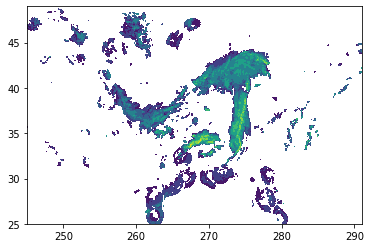

In [176]:
plt.contourf(data_lon,data_lat,data_refl_2d)

#### Debug: Convective/Stratiform Masking process:

In [177]:
import numpy as np
import scipy.ndimage as ndi
import os

In [178]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    
    re = 6371.0
    
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    return c * re

In [179]:
def mask_conv_area_C(bkgnd_range_id, outarray, latarray, lonarray, grid_res, dist_thresh, assign_value):
    
    ## Set the Box Size for processing speed:
    ## The box_size should be at least 5-km by the grid_res according to SHY95.
    box_size = np.ceil((5/(grid_res*100)))
    box_size = int(box_size)
    
    ## Loop through each Convective Center:
    for ii in range(0, len(bkgnd_range_id[0])):
        
        ## Get the Lat/Lon for the Convective Center:
        lat_ind = bkgnd_range_id[0][ii]
        lon_ind = bkgnd_range_id[1][ii]
        
        lat1 = latarray[lat_ind, lon_ind]
        lon1 = lonarray[lat_ind, lon_ind]

        ## Get just the box area (box_size) surrounding the Convective Center:
        i_lat_min = np.max([0, lat_ind-box_size])
        i_lat_max = np.min([latarray.shape[0], lat_ind+box_size])

        i_lon_min = np.max([0, lon_ind-box_size])
        i_lon_max = np.min([lonarray.shape[1], lon_ind+box_size])

        lat2 = latarray[i_lat_min:i_lat_max+1, i_lon_min:i_lon_max+1]
        lon2 = lonarray[i_lat_min:i_lat_max+1, i_lon_min:i_lon_max+1]

        ## Calculate the array of distance (in the box) to the convective center:
        d = haversine(lat1, lon1, lat2, lon2)

        ## Mask the surrounding Convective Area according to the distance threshold:
        close_d = np.where(d <= dist_thresh)
        
        if len(close_d[0]):
            close_d_global = ( close_d[0] + lat_ind - box_size
                             , close_d[1] + lon_ind - box_size
                             )
            outarray[close_d_global] = assign_value

    return outarray

In [187]:
def conv_stra_sep(dbz, lat, lon, grid_res, coor_type, method, CoreThresh=40.0, tune_thresh=42.43, bg_diff=10, fill_ndbz=-30.0):
    
    ## Function arguments settings:
    # coor_type = 'C' if coor_type is None else coor_type 
    # method = 'SHY' if method is None else method
    assert coor_type in ['C', 'L'] # make sure the coordinates type is either "C"artesian or "L"ambert-conformal.
    assert method in ['SHY', 'YH'] # make sure the method is either SHY or YH
    
    ## Check if LAT/LON coordinates are in 2-D, otherwise, MESH it:
    if lat.ndim == 1:
        lon2d, lat2d = np.meshgrid(lon, lat)
    elif lat.ndim == 2:
        lon2d, lat2d = lon, lat
    else:
        raise ValueError('Please check the dimensions of the LAT/LON coordinates!')
    #print(lat2d.ndim)
    #print(lat2d.shape)
    
    ## Filter out the NaN in the reflectivity data:
    dbz = np.nan_to_num(dbz, nan=fill_ndbz)
    
    ## Initialize the mask fields:
    cs = np.full_like(dbz, -1) # Conv./Stra. Mask.
    # cc = np.zeros_like(cs) - 1     # Convective Centers.
    
    ## Set good/bad data booleans:
    ## The bad indicates missing dBZ data points or dBZ <= 0 
    ## (The smallest dBZ in models runs is -30.0; and the dBZ is simulated as S-band radar(?)):
    # boo_bad = (dbz == np.nan)
    # boo_good = np.logical_not(boo_bad)
    
    ## Set the Conv./Stra. Masks anywhere data is good and dBZ greater than 15 dBZ (YH97, 98), give it a 0.
    ## 0 is stratiform:
    cs[(dbz >= 15.0)] = 0
    
    ## Fill the missing grids with specified dBZ values:
    # dbz[boo_bad] = fill_dbz

    ## Calculate a smoothed (averaged) background reflectivity field using a filter:
    ## According to SHY95, a 11-km radius circle was used to mimic the 400-km^2 area from Churchill and Houze (1984).
    ## Herein, we directly use the 20-km length (sqrt(400)) divided by the grid_res (4-km in this case) for the filter size.
            
    ## Calculate linear reflectivity:
    zlin = 10.**(dbz/10.)
    
    # bkgnd_lin = ndi.median_filter(zlin, size=, mode='nearest')
    if coor_type == 'C':
        bkgnd_lin = ndi.median_filter(zlin, size=10, mode='nearest') # Rough estimated distance!
    elif coor_type == 'L':
        bkgnd_lin = ndi.uniform_filter(zlin, size=20/grid_res, mode='nearest')
    else:
        raise ValueError('The coordinates type is not defined!')

    bkgnd = 10.*np.log10(bkgnd_lin)
    # bkgnd[boo_bad] = fill_dbz
    
    ## Convective Centers identification 1: Intensity (SHY95):
    cc = np.where( (dbz >= CoreThresh), 1, -1 )
    
    ## Convective Centers identification 2: Peakedness (SHY95):
    ## (a): Function (2) top in SHY95.
    
    CCI2a = (bkgnd < 0.) & ((dbz - bkgnd) >= bg_diff)
    cc[CCI2a] = 21

    ## Convective Centers identification 2: Peakedness (SHY95):
    ## (b): Function (2) middle in SHY95.
    
    if method == 'SHY':
        CCI2b = (bkgnd >= 0.) & (bkgnd < tune_thresh) & (dbz-bkgnd >= (bg_diff-(bkgnd**2.)/180.))
    elif method == 'YH':
        # This line uses YH (1998) climatological tuning algorithm (a=10, b=100):
        CCI2b = (bkgnd >= 0.) & (bkgnd < tune_thresh) & (dbz-bkgnd > 10.*np.cos((np.pi*bkgnd)/(2.*100.)))
    else:
        raise ValueError('The method is not defined!')

    cc[CCI2b] = 22
    
    ## Convective Centers identification 2: Peakedness (SHY95):
    ## (c): Function (2) bottom in SHY95.

    CCI2c = (bkgnd >= tune_thresh)
    cc[CCI2c] = 23

    ## Convective Centers identification 3: Surrounding area (SHY95):
    ## Use the medium relation as in Fig.6b of SHY95.
    
    if coor_type == 'C':
    
        bkgnd_range_id = np.where((cc > 0) & (bkgnd <= 25.)) # & (bkgnd >= 15.)
        # print(bkgnd_range_id)
        if len(bkgnd_range_id[0]):
            cs = mask_conv_area_C(bkgnd_range_id, cs, lat2d, lon2d, grid_res, 1.0, 1)
            # cs[bkgnd_range_id] = 1

        bkgnd_range_id = np.where((cc > 0) & (bkgnd > 25.) & (bkgnd <= 30.))
        if len(bkgnd_range_id[0]):
            cs = mask_conv_area_C(bkgnd_range_id, cs, lat2d, lon2d, grid_res, 2.0, 2)
            # cs[bkgnd_range_id] = 2

        bkgnd_range_id = np.where((cc > 0) & (bkgnd > 30.) & (bkgnd <= 35.))
        if len(bkgnd_range_id[0]):
            cs = mask_conv_area_C(bkgnd_range_id, cs, lat2d, lon2d, grid_res, 3.0, 3)
            # cs[bkgnd_range_id] = 3

        bkgnd_range_id = np.where((cc > 0) & (bkgnd > 35.) & (bkgnd <= 40.))
        if len(bkgnd_range_id[0]):
            cs = mask_conv_area_C(bkgnd_range_id, cs, lat2d, lon2d, grid_res, 4.0, 4)
            # cs[bkgnd_range_id] = 4

        bkgnd_range_id = np.where((cc > 0) & (bkgnd > 40.))
        if len(bkgnd_range_id[0]):
            cs = mask_conv_area_C(bkgnd_range_id, cs, lat2d, lon2d, grid_res, 5.0, 5)
            # cs[bkgnd_range_id] = 5
    
    elif coor_type == 'L':
        
        bkgnd_range_id = np.where((cc > 0) & (bkgnd <= 25.)) # & (bkgnd >= 15.)  
        if len(bkgnd_range_id[0]):
            cs = mask_conv_area_L(bkgnd_range_id, cs, grid_res, 1.0, 1)

        bkgnd_range_id = np.where((cc > 0) & (bkgnd > 25.) & (bkgnd <= 30.))
        if len(bkgnd_range_id[0]):
            cs = mask_conv_area_L(bkgnd_range_id, cs, grid_res, 2.0, 2)
            
        bkgnd_range_id = np.where((cc > 0) & (bkgnd > 30.) & (bkgnd <= 35.))
        if len(bkgnd_range_id[0]):
            cs = mask_conv_area_L(bkgnd_range_id, cs, grid_res, 3.0, 3)
            
        bkgnd_range_id = np.where((cc > 0) & (bkgnd > 35.) & (bkgnd <= 40.))
        if len(bkgnd_range_id[0]):
            cs = mask_conv_area_L(bkgnd_range_id, cs, grid_res, 4.0, 4)
            
        bkgnd_range_id = np.where((cc > 0) & (bkgnd > 40.))
        if len(bkgnd_range_id[0]):
            cs = mask_conv_area_L(bkgnd_range_id, cs, grid_res, 5.0, 5)
                        
    else:
        raise ValueError('The coordinates type is not defined!')
        
        
    return cs, cc, bkgnd

In [188]:
start = time.time()

cs, cc, bkgnd = conv_stra_sep(data_refl_2d, data_lat, data_lon, 0.02, 'C', 'SHY')

end = time.time()

print("\nRUNTIME：%f SEC" % (end - start))
print("\nRUNTIME：%f MIN" % ((end - start)/60))
print("\nRUNTIME：%f HOUR" % ((end - start)/3600))


RUNTIME：3.943681 SEC

RUNTIME：0.065728 MIN

RUNTIME：0.001095 HOUR


In [189]:
CS_mask = cs

In [148]:
print(np.max(data_refl_2d))
print(np.nanmax(cs))
print(np.nanmax(cc))
print(np.nanmax(bkgnd))


nan
5.0
23
52.49881546967714


#### Function: Convective/Stratiform separation:

In [163]:
def CS_separation(refl, lat, lon):

    ## Convective/Stratiform separation:
    cs, cc, bkgnd = csm.conv_stra_sep(refl, lat, lon, 'C', 0.02)
    
    # cs[np.where(refl <= 0.0)] = np.nan
    # cs[np.where(np.isnan(refl))] = -1
    
    return cs


# cs, cc, bkgnd = csm.conv_stra_sep(data_refl_2d, data_lat, data_lon, 0.02, 'C', 'SHY')

In [164]:
start = time.time()

## Convective/Stratiform Separation:
CS_mask_single = CS_separation( data_refl_2d
                              , data_lat
                              , data_lon
                              )

CS_mask = CS_mask_single

end = time.time()

print("\nRUNTIME：%f SEC" % (end - start))
print("\nRUNTIME：%f MIN" % ((end - start)/60))
print("\nRUNTIME：%f HOUR" % ((end - start)/3600))

#### Function: creating new map:

In [190]:
def new_map(fig):
    
    # proj = ccrs.LambertConformal()
    proj = ccrs.PlateCarree(central_longitude=0)
    
    # ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax = plt.axes(projection=proj)
    
    ## Set extent:
    # ax.set_global()
    
    ## CONUS:
    # ax.set_extent([-139, -55, 16, 60], crs=proj)    
    ## 9/13 case:
    # ax.set_extent([-115, -95, 32, 43], crs=proj)    
    ## 4/27 case:
    ax.set_extent([-96, -84, 33, 41], crs=proj)
    ## Test:
    # ax.set_extent([-86, -76, 25, 33], crs=proj)
    # ax.set_extent([-86, -65, 25, 45], crs=proj)
    
    ## Add coast lines:
    ax.coastlines('10m', 'black', linewidth=1)
    
    ## Add features:
    ax.add_feature(cfeat.BORDERS)
    ax.add_feature(cfeat.OCEAN, edgecolor=None, fc='none')
    
    ## Grab state shapefile:
    state_borders = cfeat.NaturalEarthFeature(category='cultural', 
                                              name='admin_1_states_provinces_lines', 
                                              scale='110m', 
                                              facecolor='none',
                                              edgecolor='k'
                                             )
    
    ax.add_feature(state_borders, linewidth=0.8)
    
    ## Add the gridlines:
    latlon_grid_int = 2
    ax_gl = ax.gridlines(crs=ccrs.PlateCarree()
                        ,linewidth=0.5
                        ,color='#454545' 
                        ,alpha=0.9
                        ,linestyle='--'
                        ,draw_labels=True 
                        ,dms=True
                        ,x_inline=False 
                        ,y_inline=False
                        ,xlocs=np.arange(-180, 181, latlon_grid_int)
                        ,ylocs=np.arange(-90, 91, latlon_grid_int)
                        )
    ax_gl.top_labels = False
    ax_gl.right_labels = False
    ax_gl.bottom_labels = True
    ax_gl.left_labels = True
    ax_gl.xlabel_style = {'size': 12, 'weight': 'bold'}
    ax_gl.ylabel_style = {'size': 12, 'weight': 'bold'}
    
    
    return ax

#### Do the plot:

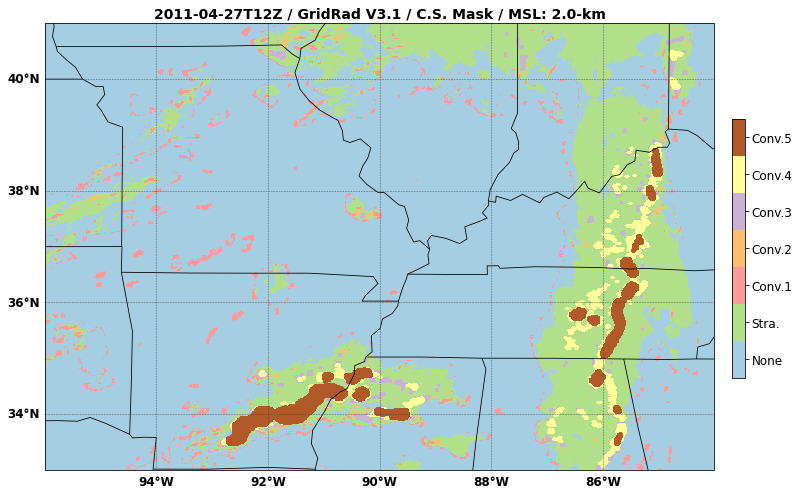

In [191]:
fig = plt.figure(figsize=(12,9))
ax1 = new_map(fig)
# ax1 = plt.axes(projection = ccrs.LambertConformal(central_longitude=-100, central_latitude=40))
# ax1 = plt.axes(projection = ccrs.PlateCarree())

plotting_var = CS_mask
plotting_lon = data_lon
plotting_lat = data_lat

cf1 = ax1.pcolormesh( plotting_lon, plotting_lat, plotting_var
                    , cmap=plt.cm.get_cmap('Paired', 7)
                    , vmin=-1
                    , vmax=5
                    , shading='auto'
                    )
cf1.cmap.set_under('w')


cf1_title = plt.title( file_date_time.strftime('%Y-%m-%dT%HZ') + ' / '
                     + 'GridRad V3.1 / '
                     + 'C.S. Mask / '
                     + 'MSL: ' + str(data_dict['z']['values'][msl_id]) + '-km'
                     , fontsize=14 
                     , fontweight='bold'
                     )

## Colorbar:
cbar_ax = fig.add_axes([0.92, 0.3, 0.015, 0.4])
cbar = fig.colorbar(cf1, 
                    cax=cbar_ax, 
                    fraction=0.04, 
                    ticks=np.arange(-1, 6, 1), 
                    boundaries=np.arange(-1.5, 6.5, 1))
cbar.ax.tick_params(labelsize=12)
cbar.set_ticklabels(['None', 'Stra.', 'Conv.1', 'Conv.2', 'Conv.3', 'Conv.4', 'Conv.5'])
# cbar_title = plt.title('[dBZ]', fontsize=12, y=-0.1)


## Save figure:

plt.savefig( './' + file_date_time.strftime('%Y-%m-%dT%HZ') 
           + '_GridRad_CSmask_v3_' + str(data_dict['z']['values'][msl_id]) + 'km.png'
           , bbox_inches='tight'
           , dpi=300)


#### <font color='teal'>**Supplement Codes:**</font>

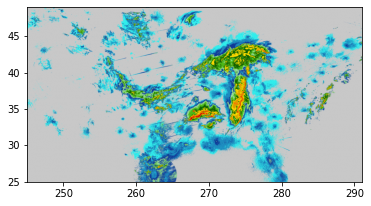

In [5]:
data = grd.read_file(file_name_dict['dbz'])
plot = grd.plot_image(data)

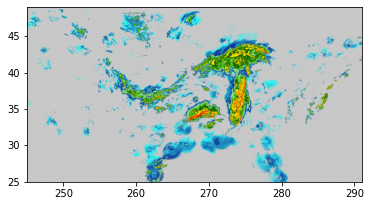

In [6]:
data = grd.read_file(file_name_dict['dbz'])
data = grd.filter(data)
plot = grd.plot_image(data)

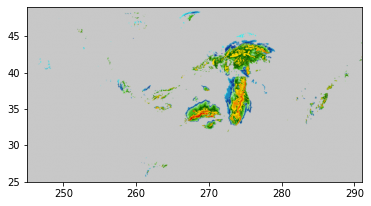

In [7]:
data = grd.read_file(file_name_dict['dbz'])
data = grd.filter(data)
data = grd.remove_clutter(data, skip_weak_ll_echo=0)
plot = grd.plot_image(data)

### Main Function:

In [31]:
def main_function(file_date_time):
    
    ## Set file datetime:
    # file_date_time = dt.datetime(2013, 9, 13, 0, 0, 0, tzinfo=pytz.utc)
    print('\nProcessing: {}'.format(file_date_time.strftime('%Y%m%d')), end=': ')
    
    ## Set input files paths and names:
    file_name_dict = set_input_names(file_date_time)

    ## Get the 3-hourly time list:
    nc_wrf_dbz = Dataset(file_name_dict['dbz'], mode='r')
    wrf_3hour_list = wrf.extract_times(nc_wrf_dbz, timeidx=wrf.ALL_TIMES, meta=False, do_xtime=False)
    nc_wrf_dbz.close()
    
    ## Open dBZ data array and append calculated data:
    ds_wrf_dbz = xr.open_dataset(file_name_dict['dbz'])
    
    ## Set sigma level index:
    interp_vertical_lev = 12 # number in levels.
    
    for hi in range(len(wrf_3hour_list)):
        
        print(str(hi) + ' | ', end=' ')

        ## Get dBZ data:
        da_wrf_dbz = ds_wrf_dbz['dBZ'].isel(Time=hi)
        
        ## Get dBZ data at specified sigma level:
        dbz_sigmalev = da_wrf_dbz[interp_vertical_lev,:,:]
        
        ## Convective/Stratiform Separation:
        ## !!! Make sure the array for the masking is in numpy array format (speed issue) !!!
        CS_mask_single = CS_separation( dbz_sigmalev.data
                                      , dbz_sigmalev.XLAT.data
                                      , dbz_sigmalev.XLONG.data
                                      )
        
        ## Stack the CS mask according to hours:
        if ( hi == 0 ):
            # CS_mask = CS_mask_single
            CS_mask = np.expand_dims(CS_mask_single, axis=0)
        else:
            # CS_mask = xr.concat([CS_mask, CS_mask_single], dim='TimeDim')
            CS_mask = np.append(CS_mask, np.expand_dims(CS_mask_single, axis=0), axis=0)
            
        # print(type(CS_mask))
        # print(CS_mask.shape)
        
    ## Add CS mask to dBZ dataset:
    # ds_wrf_dbz['CS_mask'] = (['Time', 'south_north', 'west_east'], CS_mask)
    
    ## Add attributes to dBZ and Convective/Stratiform mask:
    # ds_wrf_dbz.CS_mask.attrs['long_name'] = 'Convective/Stratiform Mask'
    # ds_wrf_dbz.CS_mask.attrs['description'] = 'Derived mask for convective (1-5) and stratiform (0) echos at sigma level: 12'
    
    ## Save to NetCDF file:
    # ds_wrf_dbz.to_netcdf(file_name_dict['dbz'],'a')
    # ds_wrf_dbz.to_netcdf('./test.nc')
    
    ds_wrf_dbz.close()
    
    ## Save & Update to NetCDF file:
    nc_wrf_dbz = Dataset(file_name_dict['dbz'], mode='r+')
    
    nc_wrf_dbz['CS_mask'][:] = CS_mask
    nc_wrf_dbz['CS_mask'].description = 'Derived mask for convective (1-5) and stratiform (0) echos at sigma level: 12'

    nc_wrf_dbz.close()

    # return CS_mask



### Main Program:

In [32]:
start = time.time()


## WRF Model Simulation Category:
wrf_sim_type = 'CTRL3D'
# wrf_sim_type = 'PGW3D'

## Loop through a period:
target_date_range = pd.date_range(start='2005-10-25', end='2005-10-25', tz=pytz.utc)

for dayi in target_date_range:
        
    ## Derive Convective/Stratiform mask and Update the NetCDF file:
    main_function(dayi)

    
end = time.time()

print("\nRUNTIME：%f SEC" % (end - start))
print("\nRUNTIME：%f MIN" % ((end - start)/60))
print("\nRUNTIME：%f HOUR" % ((end - start)/3600))
    


Processing: 20051025: 0 |  1 |  2 |  3 |  4 |  5 |  6 |  7 |  
RUNTIME：3.618760 SEC

RUNTIME：0.060313 MIN

RUNTIME：0.001005 HOUR


In [29]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y
